# End-to-End Data Cleaning Pipeline with Raha and Baran (Minimal and Integrated)
We build an end-to-end data cleaning pipeline with our configuration-free error detection and correction systems, Raha and Baran.

In [1]:
import pandas
import IPython.display
import ipywidgets

import raha

## 1. Instantiating the Detection and Correction Classes
We first instantiate the `Detection` and `Correction` classes.

In [2]:
from raha import analysis_utilities
app_1 = raha.Detection()
app_2 = raha.Correction()

# How many tuples would you label?
app_1.LABELING_BUDGET = 20
app_2.LABELING_BUDGET = 0

# Would you like to see the logs?
app_1.VERBOSE = True
app_2.VERBOSE = True

## 2. Instantiating the Dataset
We next load and instantiate the dataset object.

In [3]:
dataset_dictionary = {
        "name": "hospital",
        "path": "datasets/hospital/dirty.csv",
        "clean_path": "datasets/hospital/clean.csv"
    }
d = app_1.initialize_dataset(dataset_dictionary)
d.dataframe.head()

,index,provider_number,name,address_1,address_2,address_3,city,state,zip,county,phone,type,owner,emergency_service,condition,measure_code,measure_name,score,sample,state_average
0,1,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-card-2,surgery patients who were taking heart drugs c...,empty,empty,al_scip-card-2
1,2,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-1,surgery patients who were given an antibiotic ...,empty,empty,al_scip-inf-1
2,3,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-2,surgery patients who were given the right kind...,empty,empty,al_scip-inf-2
3,4,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birminghxm,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-3,surgery patients whose preventive antibiotics ...,empty,empty,al_scip-inf-3
4,5,10018,callahan eye foundation hospital,1720 university blvd,empty,empty,birmingham,al,35233,jefferson,2053258100,acute care hospitals,voluntary non-profit - private,yes,surgical infection prevention,scip-inf-4,all heart surgery patients whose blood sugar (...,empty,empty,al_scip-inf-4


## 3. Generating Features and Clusters
Raha runs (all or the promising) error detection strategies on the dataset. This step could take a while because all the strategies should be run on the dataset. Raha then generates a feature vector for each data cell based on the output of error detection strategies. Raha next builds a hierarchical clustering model for our clustering-based sampling approach.

In [4]:
app_1.run_strategies(d)
app_1.generate_features(d)
app_1.build_clusters(d)

I just load strategies' results as they have already been run on the dataset!


776 strategy profiles are collected.
54 Features are generated for column 0.
77 Features are generated for column 1.
61 Features are generated for column 2.
71 Features are generated for column 3.
0 Features are generated for column 4.
0 Features are generated for column 5.
65 Features are generated for column 6.
47 Features are generated for column 7.
77 Features are generated for column 8.
72 Features are generated for column 9.
76 Features are generated for column 10.
68 Features are generated for column 11.
57 Features are generated for column 12.
48 Features are generated for column 13.
62 Features are generated for column 14.
68 Features are generated for column 15.
73 Features are generated for column 16.
69 Features are generated for column 17.
71 Features are generated for column 18.
71 Features are generated for column 19.
A hierarchical clustering model is built for column 0.
A hierarchical clustering model is built for column 1.
A hierarchical clustering model is built for 

## 4. Interactive Tuple Sampling and Labeling
Raha then iteratively samples a tuple. We should label data cells of each sampled tuple.

In [5]:
def on_button_clicked(_):
    for j in range(0, len(texts)):
        cell = (d.sampled_tuple, j)
        error_label = 0
        correction = texts[j].value
        if d.dataframe.iloc[cell] != correction:
            error_label = 1
        d.labeled_cells[cell] = [error_label, correction]
    d.labeled_tuples[d.sampled_tuple] = 1

app_1.sample_tuple(d)
print("Fix the dirty cells in the following sampled tuple.")
sampled_tuple = pandas.DataFrame(data=[d.dataframe.iloc[d.sampled_tuple, :]], columns=d.dataframe.columns)
IPython.display.display(sampled_tuple)  
texts = [ipywidgets.Text(value=d.dataframe.iloc[d.sampled_tuple, j]) for j in range(d.dataframe.shape[1])]
button = ipywidgets.Button(description="Save the Annotation")
button.on_click(on_button_clicked)
output = ipywidgets.VBox(children=texts + [button])
IPython.display.display(output)

Tuple 56 is sampled.
Fix the dirty cells in the following sampled tuple.


,index,provider_number,name,address_1,address_2,address_3,city,state,zip,county,phone,type,owner,emergency_service,condition,measure_code,measure_name,score,sample,state_average
56,57,10005,marshall medical center south,2505 u s highway 431 north,empty,empty,boxz,al,35957,marshall,2565938310,acute care hospitals,government - hospital district or authority,yes,pneumonia,pn-3b,pneumonia patients whose initial emergency roo...,97%,120 patients,al_pn-xb


For the sake of time, we use the ground truth of the dataset to label tuples below.

In [6]:
%%capture
while len(d.labeled_tuples) < app_1.LABELING_BUDGET:
    app_1.sample_tuple(d)
    if d.has_ground_truth:
        app_1.label_with_ground_truth(d)

## 5. Propagating User Labels and Predicting the Labels
Raha then propagates each user label through its cluster. Raha then trains and applies one classifier per data column to predict the label of the rest of data cells.

In [7]:
app_1.propagate_labels(d)
app_1.predict_labels(d)

The number of labeled data cells increased from 400 to 16347.
A classifier is trained and applied on column 0.
A classifier is trained and applied on column 1.
A classifier is trained and applied on column 2.
A classifier is trained and applied on column 3.
A classifier is trained and applied on column 4.
A classifier is trained and applied on column 5.
A classifier is trained and applied on column 6.
A classifier is trained and applied on column 7.
A classifier is trained and applied on column 8.
A classifier is trained and applied on column 9.
A classifier is trained and applied on column 10.
A classifier is trained and applied on column 11.
A classifier is trained and applied on column 12.
A classifier is trained and applied on column 13.
A classifier is trained and applied on column 14.
A classifier is trained and applied on column 15.
A classifier is trained and applied on column 16.
A classifier is trained and applied on column 17.
A classifier is trained and applied on column 18

## 6. Initializing and Updating the Error Corrector Models
Baran initializes the error corrector models. Baran then iteratively samples a tuple. We should label data cells of each sampled tuple. It then udpates the models accordingly and generates a feature vector for each pair of a data error and a correction candidate. Finally, it trains and applies a classifier to each data column to predict the final correction of each data error. Since we already labeled tuples for Raha, we use the same labeled tuples and do not label new tuples here.

In [8]:
app_2.initialize_models(d)
app_2.initialize_dataset(d)
for si in d.labeled_tuples:
    d.sampled_tuple = si
    app_2.update_models(d)
    app_2.generate_features(d)
    app_2.predict_corrections(d)

The error corrector models are initialized.
The error corrector models are updated with new labeled tuple 621.
18153 pairs of (a data error, a potential correction) are featurized.
Prediction Method in this step:
    Column 6: Train
    Column 7: Train
    Column 10: Train
    Column 11: No train 1
    Column 12: Train
    Column 14: Train
    Column 15: Train
    Column 16: Train
    Column 17: Train
    Column 18: Train
    Column 19: Train
Train sizes in this step:
    Column 6: 45
    Column 7: 2
    Column 10: 45
    Column 11: 1
    Column 12: 13
    Column 14: 12
    Column 15: 93
    Column 16: 84
    Column 17: 54
    Column 18: 600
    Column 19: 52
Corrections identified in this step:
    Column 6: 51 Mean correction confidence: 0.9999999999999999
    Column 7: 24 Mean correction confidence: 0.9999999999999997
    Column 10: 33 Mean correction confidence: 0.9999999999999998
    Column 11: 31.0 Mean correction confidence: 1.0
    Column 12: 12 Mean correction confidence: 0.99

## 7. Storing Results
Both Raha and Baran can also store the error detection/correction results.

In [9]:
app_1.store_results(d)
app_2.store_results(d)

The results are stored in datasets/hospital/raha-baran-results-hospital/error-detection/detection.dataset.
The results are stored in datasets/hospital/raha-baran-results-hospital/error-correction/correction.dataset.


## 8. Evaluating the Data Cleaning Task
We can finally evaluate our data cleaning task.

In [10]:
edp, edr, edf = d.get_data_cleaning_evaluation(d.detected_cells)[:3]
ecp, ecr, ecf = d.get_data_cleaning_evaluation(d.corrected_cells)[-3:]

evaluation_df = pandas.DataFrame(columns=["Task", "Precision", "Recall", "F1 Score"])
evaluation_df = evaluation_df.append({"Task": "Error Detection (Raha)", "Precision": "{:.2f}".format(edp), 
                                      "Recall": "{:.2f}".format(edr), "F1 Score": "{:.2f}".format(edf)}, ignore_index=True)
evaluation_df = evaluation_df.append({"Task": "Error Correction (Baran)", "Precision": "{:.2f}".format(ecp), 
                                      "Recall": "{:.2f}".format(ecr), "F1 Score": "{:.2f}".format(ecf)}, ignore_index=True)
evaluation_df.head()

/home/adrian/source/MA/raha/raha/dataset.py:123: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if correction_dictionary[cell] == actual_errors[cell]:


,Task,Precision,Recall,F1 Score
0,Error Detection (Raha),0.95,0.58,0.72
1,Error Correction (Baran),0.70,0.43,0.53


In [17]:
import importlib
importlib.reload(analysis_utilities)

<module 'raha.analysis_utilities' from '/home/adrian/source/MA/raha/raha/analysis_utilities.py'>

In [11]:
actual_errors = d.get_actual_errors_dictionary()

Histograms of the probabilities of the detection algorithm by (label, true label)


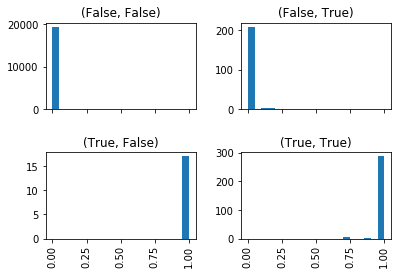

In [12]:
analysis_utilities.detection_evaluation(d, actual_errors)

In [16]:
correction_confidence_df = analysis_utilities.get_correction_confidence_df(d, actual_errors)

,cell,confidence,detection_correct,correct
0,"(207, 6)",1.0,True,True
1,"(3, 6)",1.0,True,True
2,"(7, 6)",1.0,True,True
3,"(79, 6)",1.0,True,False
4,"(88, 6)",1.0,True,False
5,"(93, 6)",1.0,True,False
6,"(212, 6)",1.0,True,True
7,"(311, 6)",1.0,True,False
8,"(367, 6)",1.0,True,False
9,"(437, 6)",1.0,True,False


In [20]:
(correction_confidence_df["confidence"] < 0.98).sum()

0

Distribution of confidences for wrong (False) and correct (True) corrections:


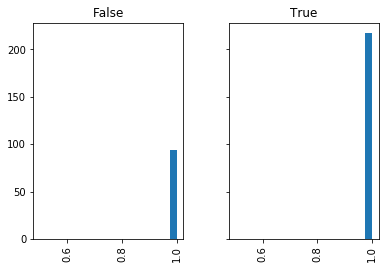

In [18]:
analysis_utilities.correction_confidence_distributions(correction_confidence_df)

Empirical probability of a correction being wrong given its confidence:


/home/adrian/anaconda3/envs/raha/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


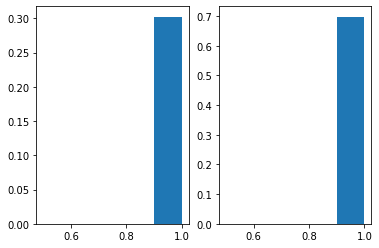

In [15]:
f = analysis_utilities.correction_correctness_by_confidence(correction_confidence_df)
f.show()